# Quickstart tutorial

This tutorial will introduce the basic concepts of this new version of PolSARpro in python.

It is important to notice that the toolbox relies on Xarray. Here we only describe the basics required to run PolSARpro and refer the reader to https://docs.xarray.dev/en/stable/ for mode details.

## Loading data

First we need to import some data. The demo dataset (TODO: host the data somewhere) has been prepared using SNAP and exported in the NetCDF-BEAM. NetCDF is the format recommended by Xarray as it was used as they share the same data model.

Let's first open the data using the `open_netcdf_beam` function.

In [16]:
from polsarpro.io import open_netcdf_beam

# change to your data path
data_path = "/data/psp/test_files/SAN_FRANCISCO_ALOS1_slc.nc"
out_path = "/data/psp/res"
S = open_netcdf_beam(data_path)

The variable `S` has been recognized by the reader as a 2x2 Sinclair matrix. It has been imported in a structure called `xarray.Dataset`. 
In a jupyter notebook it may be inspected as:

In [17]:
S

<xarray.Dataset> Size: 736MB
Dimensions:  (y: 18432, x: 1248)
Coordinates:
  * y        (y) int64 147kB 0 1 2 3 4 5 ... 18426 18427 18428 18429 18430 18431
  * x        (x) int64 10kB 0 1 2 3 4 5 6 ... 1241 1242 1243 1244 1245 1246 1247
Data variables:
    hh       (y, x) complex64 184MB dask.array<chunksize=(576, 624), meta=np.ndarray>
    hv       (y, x) complex64 184MB dask.array<chunksize=(576, 624), meta=np.ndarray>
    vv       (y, x) complex64 184MB dask.array<chunksize=(576, 624), meta=np.ndarray>
    vh       (y, x) complex64 184MB dask.array<chunksize=(576, 624), meta=np.ndarray>
Attributes:
    poltype:      S
    description:  Scattering matrix

Each channel is represented by a data variable and may be accessed using the dot notation:

In [18]:
# Access to the hh polarization channel
S.hh

<xarray.DataArray 'hh' (y: 18432, x: 1248)> Size: 184MB
dask.array<add, shape=(18432, 1248), dtype=complex64, chunksize=(576, 624), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) int64 147kB 0 1 2 3 4 5 ... 18426 18427 18428 18429 18430 18431
  * x        (x) int64 10kB 0 1 2 3 4 5 6 ... 1241 1242 1243 1244 1245 1246 1247

Each variable is a dask array which is divided into smaller chunks to be processed in parallel to improve performance.
One important thing is that the data is not loaded into memory at this point. This is called lazy loading and allows to execute processing only when the result is required. More on that later.

To convert the S matrix to other types, we can use utilities:

In [19]:
from polsarpro.util import S_to_T3

T3 = S_to_T3(S)

Let's now look at this new variable:

In [20]:
T3

<xarray.Dataset> Size: 828MB
Dimensions:  (y: 18432, x: 1248)
Coordinates:
  * y        (y) int64 147kB 0 1 2 3 4 5 ... 18426 18427 18428 18429 18430 18431
  * x        (x) int64 10kB 0 1 2 3 4 5 6 ... 1241 1242 1243 1244 1245 1246 1247
Data variables:
    m11      (y, x) float32 92MB dask.array<chunksize=(576, 624), meta=np.ndarray>
    m22      (y, x) float32 92MB dask.array<chunksize=(576, 624), meta=np.ndarray>
    m33      (y, x) float32 92MB dask.array<chunksize=(576, 624), meta=np.ndarray>
    m12      (y, x) complex64 184MB dask.array<chunksize=(576, 624), meta=np.ndarray>
    m13      (y, x) complex64 184MB dask.array<chunksize=(576, 624), meta=np.ndarray>
    m23      (y, x) complex64 184MB dask.array<chunksize=(576, 624), meta=np.ndarray>
Attributes:
    poltype:      T3
    description:  Coherency matrix (3x3)

The output has been automatically converted to a new polarimetric type `T3` representing the coherency matrix. Now the elements of the matrix are accessed as:

In [21]:
T3.m12

<xarray.DataArray 'm12' (y: 18432, x: 1248)> Size: 184MB
dask.array<mul, shape=(18432, 1248), dtype=complex64, chunksize=(576, 624), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) int64 147kB 0 1 2 3 4 5 ... 18426 18427 18428 18429 18430 18431
  * x        (x) int64 10kB 0 1 2 3 4 5 6 ... 1241 1242 1243 1244 1245 1246 1247

For storage optimization, PolSARpro takes advantage of the Hermitian structure of the matrix and stores only diagonal and upper elements.

To ensure its algorithms is applied to valid polarimetric types, PolSARpro looks for a `poltype` attribute, which may be accessed as:

In [22]:
T3.poltype

'T3'

A human readable description may also be accessed as:

In [23]:
T3.description

'Coherency matrix (3x3)'

To compute the actual result and load the data into memory, one can simply use:

In [24]:
T3 = T3.compute()
T3

<xarray.Dataset> Size: 828MB
Dimensions:  (y: 18432, x: 1248)
Coordinates:
  * y        (y) int64 147kB 0 1 2 3 4 5 ... 18426 18427 18428 18429 18430 18431
  * x        (x) int64 10kB 0 1 2 3 4 5 6 ... 1241 1242 1243 1244 1245 1246 1247
Data variables:
    m11      (y, x) float32 92MB 0.9602 0.03807 0.1286 ... 0.01147 0.003505
    m22      (y, x) float32 92MB 0.01516 0.00855 0.00198 ... 0.001074 0.02919
    m33      (y, x) float32 92MB 0.004146 0.0003961 ... 0.001152 0.0002931
    m12      (y, x) complex64 184MB (-0.054665774+0.10755201j) ... (0.0074339...
    m13      (y, x) complex64 184MB (0.057566743+0.025828078j) ... (0.0008780...
    m23      (y, x) complex64 184MB (-0.00038435453-0.00791823j) ... (0.00087...
Attributes:
    poltype:      T3
    description:  Coherency matrix (3x3)

Now, each variable is a numpy array stored in memory. This mechanism is useful as it allows to define complex processing pipelines without storing intermediate variables in memory. It is even possible to write the result to disk without storing the whole data in memeory. For instance one may define:

In [29]:
from polsarpro.util import boxcar

# crop the data using the isel accessor, re-chunk to avoid errors when writing zarr
S_crop = S.isel(y=slice(5000, 12000)).chunk("auto")
T3 = S_to_T3(S_crop)
boxcar(T3, 5, 5).to_zarr(f"{out_path}/T3_box5x5.zarr", mode="w", consolidated=False)
# az the zarr specification is still evolving, we have to set some parameter to True to silence warnings. 

Now let's apply the H/A/$\alpha$ decomposition to our $S$ matrix:

In [26]:
from polsarpro.decompositions import h_a_alpha

res = h_a_alpha(S_crop, boxcar_size=[5, 5]).compute()

In [12]:
res

<xarray.Dataset> Size: 105MB
Dimensions:     (y: 7000, x: 1248)
Coordinates:
  * y           (y) int64 56kB 5000 5001 5002 5003 ... 11996 11997 11998 11999
  * x           (x) int64 10kB 0 1 2 3 4 5 6 ... 1242 1243 1244 1245 1246 1247
Data variables:
    entropy     (y, x) float32 35MB 0.3184 0.2005 0.2102 ... 0.8807 0.83 0.8353
    anisotropy  (y, x) float32 35MB 0.8371 0.8533 0.8641 ... 0.3772 0.3105
    alpha       (y, x) float32 35MB 16.41 10.91 11.69 ... 55.53 63.33 65.51
Attributes:
    poltype:      h_a_alpha
    description:  Results of the H/A/Alpha decomposition.

As we can see, the new dataset has a specific poltype and stores the output parameters into labeled variables. As previously they can be accessed via the dot notation e.g. `res.alpha`.
We can now plot the outputs either using matplotlib or xarray plotting capabilities:

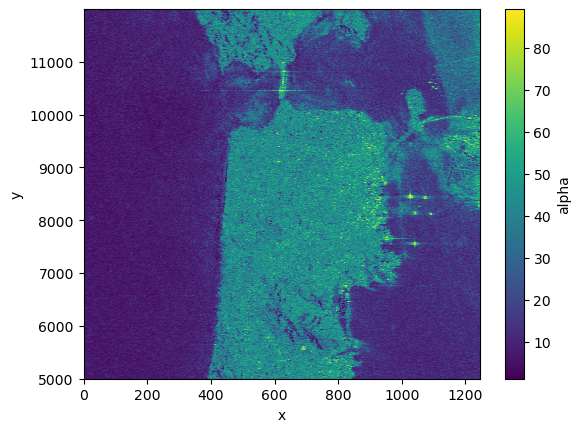

In [13]:
res.alpha.plot.imshow()

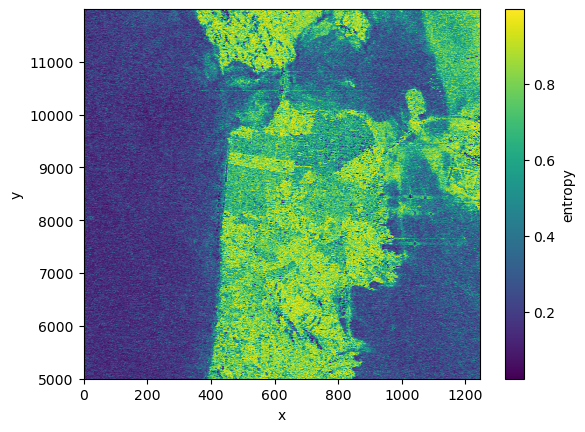

In [14]:
res.entropy.plot.imshow()

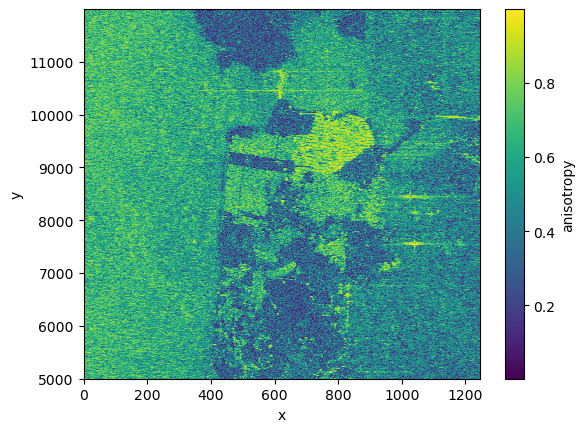

In [15]:
res.anisotropy.plot.imshow()